From CNN1 we found that the following are the best parameters: Best config: {'out_channels': 16, 'conv_kernel_size': 7, 'pool_kernel_size': 2, 'lr': 0.0005115859153484923, 'batch_size': 16}

Since we will not fine tune them this time, we will use the aforementioned ones and will focus on a more complex architecture:

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import json, re
import matplotlib.pyplot as plt
import torch.optim as optim # for PyTorch optimizers
import math
from torchvision import transforms, datasets 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report



class MediumCNN(nn.Module):
    def __init__(self, num_classes = 3):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, padding = 7 // 2, stride =1 ), # for stride = 1, conv_kernel_size // 2 seems to be the rule of thumb
            nn.BatchNorm2d(16), # normalizes activations inside the net, channel after channel. Makes training quicker and more efficient. Brings mean to zero and variance to 1
            nn.ReLU(), # breaks the linearity
            nn.MaxPool2d(2), # Pool layer that returns the highest value for each 2x2 spatial region (kernel = 2 and by default stride = kernel, so number of spatial position is 4 times smaller)
            
            nn.Conv2d(in_channels= 16, out_channels = 32, kernel_size = 3, padding = 1 ), 
            nn.BatchNorm2d(32), 
            nn.ReLU(), 
            nn.MaxPool2d(2)
            
            ) 
        self.classifier = nn.Sequential(
            nn.LazyLinear(128), # lazy layer that outputs 128 units where you do not have to specify the number of in_features upfront.
            nn.ReLU(), 
            nn.Dropout(0.5), 
            nn.Linear(128, num_classes)
        )
        

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    




In [ ]:
# Load datasets locally in the training function

img_size = (256, 256)
train_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(degrees= 15),
    transforms.ColorJitter(
        brightness = 0.2,
        saturation = 0.2,
        contrast = 0.2,
        hue = 0.1,
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5,0.5,0.5])
])


val_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5,0.5,0.5])
])


train_ds_local = datasets.ImageFolder("/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/train", transform=train_transform)
val_ds_local = datasets.ImageFolder("/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/val", transform=val_transform)

cnn = MediumCNN()


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
cnn = cnn.to(device) # moves model parameters (weights and biases) to the target device


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr = 0.0005115859153484923, momentum = 0.9)

trainloader = torch.utils.data.DataLoader(
    train_ds_local,
    batch_size = 16,
    shuffle = True,
    num_workers = 2,
)
valloader = torch.utils.data.DataLoader(
    val_ds_local,
    batch_size = 16,
    shuffle = False,
    num_workers = 2,
)

best_val_loss = math.inf

for epoch in range(30):

    print(f'Training epoch {epoch}...')
    cnn.train()
    running_loss = 0.0
    n_train = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        n_train += labels.size(0)

    train_loss = running_loss / max(n_train, 1)

    print(f'Loss = {round(train_loss, 4)}')

    cnn.eval()
    val_loss = 0.0
    total = 0
    correct = 0

    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / max(total, 1)
    val_acc = correct / max(total, 1)
    print(f'Validation accuracy: {val_acc}')
    

Training epoch 0...
Loss = 1.0325
Validation accuracy: 0.6809815950920245
Training epoch 1...
Loss = 0.8012
Validation accuracy: 0.8190184049079755
Training epoch 2...
Loss = 0.6631
Validation accuracy: 0.8558282208588958
Training epoch 3...
Loss = 0.565
Validation accuracy: 0.8895705521472392
Training epoch 4...
Loss = 0.4907
Validation accuracy: 0.9233128834355828
Training epoch 5...
Loss = 0.4871
Validation accuracy: 0.9171779141104295
Training epoch 6...
Loss = 0.4015
Validation accuracy: 0.9447852760736196
Training epoch 7...
Loss = 0.4049
Validation accuracy: 0.9171779141104295
Training epoch 8...
Loss = 0.3877
Validation accuracy: 0.941717791411043
Training epoch 9...
Loss = 0.3552
Validation accuracy: 0.9386503067484663
Training epoch 10...
Loss = 0.3415
Validation accuracy: 0.941717791411043
Training epoch 11...
Loss = 0.3167
Validation accuracy: 0.9478527607361963
Training epoch 12...
Loss = 0.295
Validation accuracy: 0.941717791411043
Training epoch 13...
Loss = 0.3118
Valid

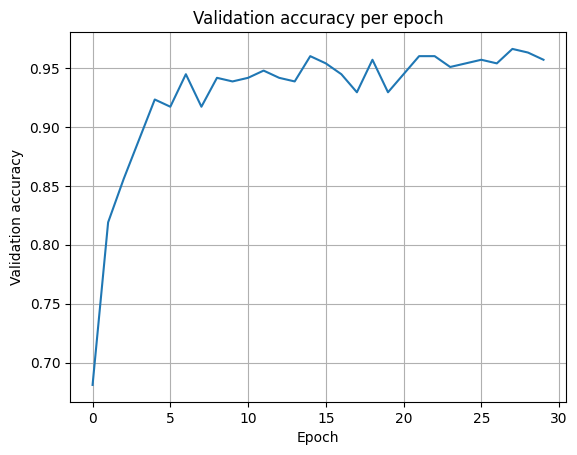

In [ ]:
path = "CNN2.ipynb"   # same folder as the notebook file
with open(path, "r", encoding="utf-8") as f:
    nb = json.load(f)

# Collect all stdout text saved in outputs
texts = []
for cell in nb.get("cells", []):
    for out in cell.get("outputs", []):
        if out.get("output_type") == "stream" and out.get("name") == "stdout":
            texts.extend(out.get("text", []))

blob = "".join(texts)

val_acc = [float(x) for x in re.findall(r"Validation accuracy:\s*([0-9]*\.?[0-9]+)", blob)]

plt.plot(range(len(val_acc)), val_acc)
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.title("Validation accuracy per epoch")
plt.grid(True)
plt.show()


We could have stopped at 6 epochs since the validation accuracy does not constantly improves after that and doesn't improve much overall

In [14]:

torch.save(cnn.state_dict(), 'trained_cnn.pth')

In [16]:


TEST_DIR = "/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/test"  


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


img_size = (256, 256)
test_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# Load test set
test_ds = datasets.ImageFolder(TEST_DIR, transform=test_transform)
print("Test classes:", test_ds.classes, "  n_test:", len(test_ds))


cnn = MediumCNN().to(device)
cnn.load_state_dict(torch.load("trained_cnn.pth", map_location=device))
cnn.eval()


# Dataloader (you can use best batchsize or set your own)
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=16,
    shuffle=False,
    num_workers=2,
)

# Evaluate
criterion = nn.CrossEntropyLoss()
total, correct, test_loss_sum = 0, 0, 0.0

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = cnn(x)
        loss = criterion(logits, y)

        bs = y.size(0)
        test_loss_sum += loss.item() * bs
        preds = logits.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += bs

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

test_loss = test_loss_sum / max(total, 1)
test_acc = correct / max(total, 1)


print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Test classes: ['paper', 'rock', 'scissors']   n_test: 331
Test loss: 0.1294
Test accuracy: 0.9668


Confusion matrix (counts):
 [[100   1   7]
 [  0 109   1]
 [  0   2 111]]


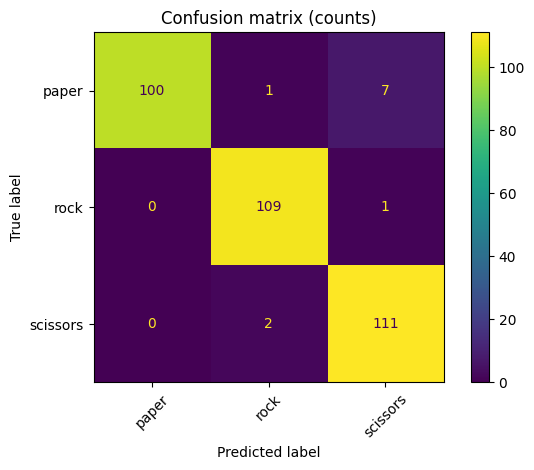

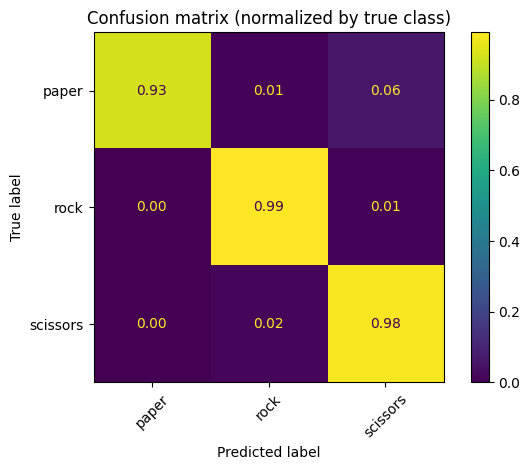


Classification report:
              precision    recall  f1-score   support

       paper     1.0000    0.9259    0.9615       108
        rock     0.9732    0.9909    0.9820       110
    scissors     0.9328    0.9823    0.9569       113

    accuracy                         0.9668       331
   macro avg     0.9687    0.9664    0.9668       331
weighted avg     0.9681    0.9668    0.9667       331



In [ ]:
# Concatenate the tensors you collected during evaluation
y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()

# Confusion matrix (counts)
cm = confusion_matrix(y_true, y_pred)  # C[i, j] = # true=i predicted=j [web:20]
print("Confusion matrix (counts):\n", cm)

# Optional: normalized by true class (rows sum to 1)
cm_norm = confusion_matrix(y_true, y_pred, normalize="true")  # normalize='true' -> row-normalized [web:20]

# Plot (counts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.classes)
disp.plot(xticks_rotation=45)
plt.title("Confusion matrix (counts)")
plt.tight_layout()
plt.show()  # ConfusionMatrixDisplay is intended for plotting a confusion matrix [web:27]

# Plot (row-normalized)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=test_ds.classes)
disp_norm.plot(xticks_rotation=45, values_format=".2f")
plt.title("Confusion matrix (normalized by true class)")
plt.tight_layout()
plt.show()  # normalize option controls how entries are normalized [web:27]

# Classification report (precision/recall/F1 per class)
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=test_ds.classes, digits=4))  # target_names labels classes [web:19]
